# New Analysis

Goals: 
- histogram
- distribution along all 3 planes, x, y, z
- break into quarters and test 2 (bijan doing halfs?)
- visualization for each of the 12 slices for density in x/y plane
- clustering along each of the planes
- Run all our tests on the "cleaned" data, see how they differ
- if we find layers, or define them, run regression/tests within them.
- Spatial point process
- plot the cluster centers and then draw the ellipsoids formed by the diagonals off the covariance matrix around each centroid


## Setting up and clearing unmasked values of 0

check shared by all, indicies from old code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2
import scipy.stats as stats

url = ('https://raw.githubusercontent.com/Upward-Spiral-Science/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # Remove lable row

# Clip data based on thresholds on x and y coordinates. Found from Bijan visual
x_bounds = (409, 3529)
y_bounds = (1564, 3124)

def check_in_bounds(row, x_bounds, y_bounds):
    if row[0] < x_bounds[0] or row[0] > x_bounds[1]: #check x inbounds
        return False
    if row[1] < y_bounds[0] or row[1] > y_bounds[1]: #check y inbounds
        return False
    if row[3] == 0:                                  # remove zeros of unmasked values
        return False
    return True

indices_in_bound = np.where(np.apply_along_axis(check_in_bounds, 1, csv, x_bounds, y_bounds))
data_clipped = csv[indices_in_bound]
n = data_clipped.shape[0]
print 'xbound:', x_bounds, ' ybound: ', y_bounds, "n shape after clipping data: ", n 


xbound: (409, 3529)  ybound:  (1564, 3124) n shape after clipping data:  36036


## Histogram of syn/unmasked (density) 

combining data snippit from bijan

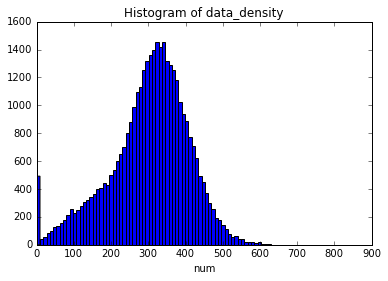

In [2]:
density = np.divide(data_clipped[:, 4],data_clipped[:, 3])*(64**3)

data_density = np.vstack((data_clipped[:,0],data_clipped[:,1],data_clipped[:,2],density))
data_density = data_density.T

bins = 100

fig = plt.figure(1)
ax = fig.gca()
plt.hist(data_density[:,3],bins)
ax.set_title('Histogram of data_density')
ax.set_xlabel('num')

plt.show()

## Checking for optimal cluster size

testing for cluster: 1
testing for cluster: 2
testing for cluster: 3
testing for cluster: 4
testing for cluster: 5
testing for cluster: 6
testing for cluster: 7
testing for cluster: 8
testing for cluster: 9
testing for cluster: 10
testing for cluster: 11
testing for cluster: 12
testing for cluster: 13
testing for cluster: 14


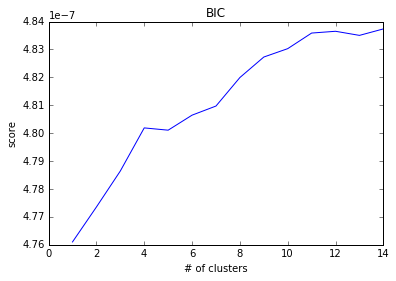

done


In [3]:
import sklearn.mixture as mixture
max_clusters = 15
bic = np.array([])
i = np.array(range(1, max_clusters))
for idx in range(1, max_clusters):
    print 'testing for cluster: ' + str(idx) 
    gmm = mixture.GMM(n_components=idx, n_iter=1000, covariance_type='diag', random_state=1)
    gmm.fit(data_density)
    bic = np.append(bic, gmm.bic(data_density))
    
fig = plt.figure(2)
ay = fig.gca()
plt.plot(i, 1.0/bic)
ay.set_title('BIC')
ay.set_ylabel('score')
ay.set_xlabel('# of clusters')


plt.show()
print 'done'

## Plotting Gaussian 

going for Gaussian



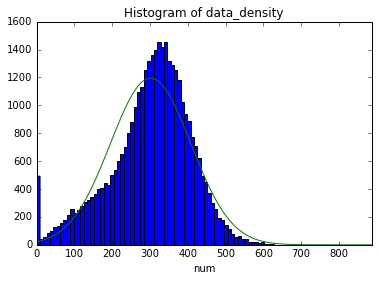

In [4]:
print 'going for Gaussian'

import matplotlib.mlab as mlab

fig = plt.figure(3)
az = fig.gca()
result = plt.hist(data_density[:,3],bins)
az.set_title('Histogram of data_density')
az.set_xlabel('num')

plt.xlim((min(data_density[:,3]), max(data_density[:,3])))

mean = np.mean(data_density[:,3])
variance = np.var(data_density[:,3])
sigma = np.sqrt(variance)
x = np.linspace(min(data_density[:,3]), max(data_density[:,3]),100)
dx = result[1][1] - result[1][0]
scale = len(data_density[:,3])*dx
plt.plot(x, mlab.normpdf(x,mean,sigma)*scale)

print 

## Regressions

Basic regressions

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
names = ['Linear Regression','SVR','KNN Regression','Random Forest Regression','Polynomial Regression']
regressions = [LinearRegression(),
               LinearSVR(C=1.0),
               KNN(n_neighbors=10, algorithm='auto'),
               RF(max_depth=5, max_features=1),
               Pipeline([('poly', PF(degree=2)),('linear', LinearRegression(fit_intercept=False))])]
k_fold = 10

print('Regression on X=(x,y,z), Y=syn/unmasked')
X = data_density[:, (0, 1, 2)] # x,y,z
Y = data_density[:, 3] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

Regression on X=(x,y,z), Y=syn/unmasked
R^2 of Linear Regression: 0.12 (+/- 0.16)
R^2 of SVR: -0.86 (+/- 0.68)
R^2 of KNN Regression: 0.20 (+/- 0.08)
R^2 of Random Forest Regression: 0.21 (+/- 0.12)
R^2 of Polynomial Regression: 0.18 (+/- 0.17)


## Regressions of x y z with density

In [10]:
# x 
print
print('Regressions on x and density')
X = data_density[:,[0]] # x,y,z
Y = data_density[:,3] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# y 
print
print('Regression on y and density')
X = data_density[:,[1]] # x,y,z
Y = data_density[:,3] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))

# z -> syn/unmasked
print
print('Regression on z and density')
X = data_density[:,[2]] # x,y,z
Y = data_density[:,3] # syn/unmasked
for idx2, reg in enumerate(regressions):
    scores = cross_validation.cross_val_score(reg, X, Y, scoring='r2', cv=k_fold)
    print("R^2 of %s: %0.2f (+/- %0.2f)" % (names[idx2], scores.mean(), scores.std() * 2))


Regressions on x and density
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -1.73 (+/- 6.47)
R^2 of KNN Regression: -0.17 (+/- 0.36)
R^2 of Random Forest Regression: -0.10 (+/- 0.23)
R^2 of Polynomial Regression: -0.01 (+/- 0.02)

Regression on y and density
R^2 of Linear Regression: 0.12 (+/- 0.15)
R^2 of SVR: -1.19 (+/- 2.59)
R^2 of KNN Regression: 0.00 (+/- 0.19)
R^2 of Random Forest Regression: 0.14 (+/- 0.16)
R^2 of Polynomial Regression: 0.14 (+/- 0.16)

Regression on z and density
R^2 of Linear Regression: -0.01 (+/- 0.04)
R^2 of SVR: -0.66 (+/- 2.78)
R^2 of KNN Regression: -0.08 (+/- 0.08)
R^2 of Random Forest Regression: 0.04 (+/- 0.06)
R^2 of Polynomial Regression: 0.01 (+/- 0.05)


## Mean and covariance of 3 and 4 clusters... meaningless graphs :(

Heavily adapted Jay's and Emily's code applied to 3 clusters, as it showed up very evenly when observing Emily's clustering visualization.

[0, 0, 0, 0]
# of samples in cluster 1: 11711
centroid:  [ 1917.13209803  2728.47186406   615.84809154   198.53145688]
cluster covariance: 
[[ 694228.44377834    3332.46934469    7326.98104205   -1012.57378398]
 [   3332.46934469  107527.12745339    4160.96306116    5206.7114939 ]
 [   7326.98104205    4160.96306116  136933.01936421    5244.09632285]
 [  -1012.57378398    5206.7114939     5244.09632285    8083.49441601]]
determinant of covariance matrix:  7.79740049612e+19

# of samples in cluster 2: 12042
centroid:  [ 2833.85301445  2154.5284006    612.52566019   353.56146845]
cluster covariance: 
[[ 177410.44297281   16206.91107624    1131.72132037    5275.82609097]
 [  16206.91107624  149135.43649091    2950.29185485    -312.71782313]
 [   1131.72132037    2950.29185485  116401.02869953    -719.86939832]
 [   5275.82609097    -312.71782313    -719.86939832    6058.23769379]]
determinant of covariance matrix:  1.79573855756e+19

# of samples in cluster 3: 12283
centroid:  [ 1155.1182

<function matplotlib.pyplot.show>

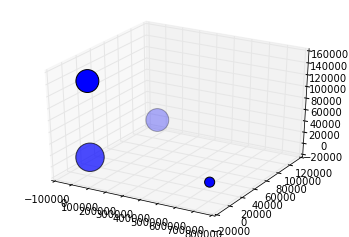

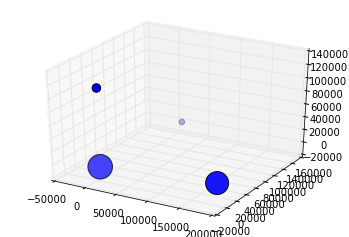

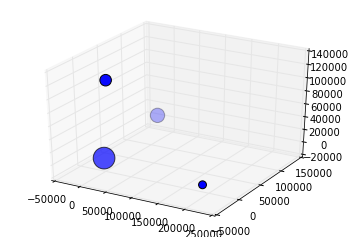

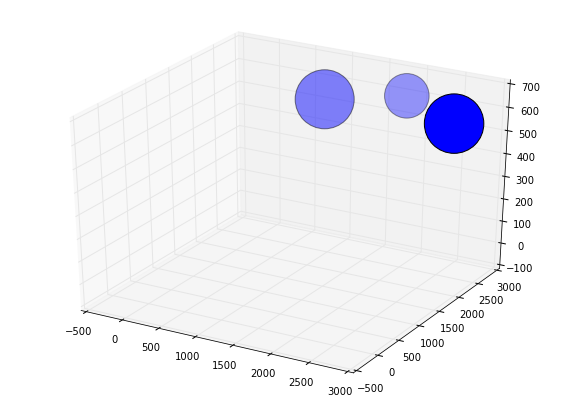

In [17]:
n_clusters = 3
###########################################
gmm = mixture.GMM(n_components=n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
clusters = [[] for i in xrange(n_clusters)]
centroidmatrix = [0]*4
print centroidmatrix

predicted = gmm.fit_predict(data_density)
for label, row in zip(predicted, data_density[:,]):
    clusters[label].append(row)

    
for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    centroidmatrix = np.vstack((centroidmatrix,np.average(clusters[i], axis=0)))
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(
       covar[:, 0], covar[:, 1], covar[:, 2],  # data
       c='blue',  # marker colour
       marker='o',  # marker shape
       s=np.absolute(covar[:,3])/10  # marker size
    )
    plt.show

print centroidmatrix

fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')
ax.scatter(
       centroidmatrix[:, 0], centroidmatrix[:, 1], centroidmatrix[:, 2],  # data
       c='blue',  # marker colour
       marker='o',  # marker shape
       s=centroidmatrix[:,3]*10  # marker size
)




plt.show

### Jay's code

In [ ]:
n_clusters = 4
####################################
gmm = mixture.GMM(n_components=
                  n_clusters, n_iter=1000, covariance_type='diag', random_state=1)
clusters = [[] for i in xrange(n_clusters)]
predicted = gmm.fit_predict(data_density)
for label, row in zip(predicted, data_density[:,]):
    clusters[label].append(row)

for i in xrange(n_clusters):
    clusters[i] = np.array(clusters[i])
    print "# of samples in cluster %d: %d" % (i+1, len(clusters[i])) 
    print "centroid: ", np.average(clusters[i], axis=0)
    print "cluster covariance: "
    covar = np.cov(clusters[i].T)
    print covar
    print "determinant of covariance matrix: ", np.linalg.det(covar)
    print

## Graph Cluster: Emily's

In [ ]:
import sklearn.cluster as cluster
from mpl_toolkits.mplot3d import Axes3D

def graph_cluster(xyz_only, clusters, centers, k):
    # randomly sample
    samples = 10000
    perm = np.random.permutation(xrange(1, len(xyz_only[:])))
    xyz_only = xyz_only[perm[:samples]]
    clusters = clusters[perm[:samples]]

    # get range for graphing
    mins = [np.amin(xyz_only[:, i]) for i in xrange(3)]
    maxs = [np.amax(xyz_only[:, i]) for i in xrange(3)]

    # following code adopted from
    # https://www.getdatajoy.com/examples/python-plots/3d-scatter-plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')

    ax.set_title('K-means, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
               xyz_only[:, 0], xyz_only[:, 1], xyz_only[:, 2],  # data
               c=clusters,  # marker colour
               marker='o',  # marker shape
               s=50  # marker size
    )

    plt.show()
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    ax.set_title('Centers, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
           centers[:, 0], centers[:, 1], centers[:, 2],  # data
           c='blue',  # marker colour
           marker='o',  # marker shape
           s=100  # marker size
    )
    plt.show()



## print centers k = 4

In [ ]:
import sklearn.cluster as cluster
from mpl_toolkits.mplot3d import Axes3D

n_clusters = 4
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(data_density[:,[0,1,2]])
centers = kmeans.cluster_centers_
print centers
graph_cluster(data_density[:,[0,1,2]], clusters, centers, n_clusters)

## print centers k = 3

In [ ]:
import sklearn.cluster as cluster
from mpl_toolkits.mplot3d import Axes3D

n_clusters = 3
kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(data_density[:,[0,1,2]])
centers = kmeans.cluster_centers_
print centers

graph_cluster(data_density[:,[0,1,2]], clusters, centers, n_clusters)

In [ ]:
print 'done'